# K12 Stem Exam Topic Modeling and Analysis

### Author: Paul Shao

### Motivation and Project Description

Concerns regarding the effectiveness of elementary and middle school’s science education have elevated significantly over the past few years. With a polarizing political landscape and an impasse between federal and state government over the increasing education achievement gap among students with drastically different family and financial backgrounds, an investigation of some of the most commonly asked science exam questions at elementary & middle schools across the U.S. can shed more light on how the current administration (both local and national) navigates the difficult task of providing a impartial, accurate, and modern science education while aligning with the socioeconomic and political interests of the regional voters.
The goal of this project is to visualize and explore the following questions surrounding elementary STEM education in the U.S.:
- What scientific topic(s) do K-12 schools in the U.S. most commonly focus on?
- How does the emphasis on the questions vary through the descriptions of the questions across
each scientific subject category?

### Datasets

Dataset Used:
To facilitate a broad understanding of how students’ understanding of different scientific subjects are assessed across K-12 schools in the U.S., I will incorporate the following dataset in my analysis:
- The Aristo Reasoning Challenge (ARC) corpus, which contains 7787 elementary and middle
school standardized exam questions drawn from 12 US states.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sklearn
import seaborn as sns
import os
import re
import plotly.express as px
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Embedding, LSTM, SpatialDropout1D

from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords 
from nltk import word_tokenize

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
qc_questions = pd.read_csv('QC-ARC-Questions.tsv',delimiter='\t',encoding='utf-8')
qc_taxonomy = pd.read_csv('QC-ARC-Taxonomy.tsv', delimiter='\t', encoding='utf-8')

In [3]:
qc_questions.head()

questionID originalQuestionID  totalPossiblePoint AnswerKey  \
0  Mercury_SC_405198             405198                   1         D   
1  Mercury_SC_415013             415013                   1         B   
2  Mercury_SC_405298             405298                   1         C   
3     VASoL_2007_3_6                  6                   1         C   
4  Mercury_SC_416525             416525                   1         A   

   isMultipleChoiceQuestion  includesDiagram  \
0                         1                0   
1                         1                0   
2                         1                0   
3                         1                0   
4                         1                0   

                                   examName  grade  year  \
0                                   Mercury      3  2015   
1                                   Mercury      3  2015   
2                                   Mercury      3  2015   
3  Virginia Standards of Learning - Science      3  2007   
4                                   Mercury      3  2015   

                                       QCLabel  \
0                     LIFE_FUNCT_ENVCOND_PLANT   
1  EARTH_INNER_INTHEAT, EARTH_INNER_PLATE_VOLC   
2                                        OTHER   
3                EARTH_HUMIMP_WHAT_HABITATDEST   
4           LIFE_FUNCT_FEATANDFUNCT_PLANT_LEAF   

                                            Question  subject category  \
0  Which of these will most likely increase a pla...      NaN    Train   
1  Which rapid changes are caused by heat from in...      NaN    Train   
2  Which invention will best help people travel q...      NaN    Train   
3  A wetland habitat can continue to support the ...      NaN    Train   
4  Randall is picking lettuce from his garden for...      NaN    Train   

        fold  
0  Challenge  
1       Easy  
2       Easy  
3  Challenge  
4       Easy

In [4]:
qc_questions['QCLabel'].value_counts()

CEL_CYCLES                                                                                    146
MAT_CHEM_ATOMIC                                                                               114
MAT_CHEM_PERIODICTAB                                                                          100
SCI_INFERENCE_EXPDESIGN                                                                        86
MAT_CHANGES_CHEMICAL                                                                           81
                                                                                             ... 
EARTH_WEATHER_WATERCYC_EVAPCOND, EARTH_WEATHER_WATERCYC_PREC                                    1
ENG_THERM_COND_CONVECT, EARTH_INNER_CMC_MANTLE                                                  1
LIFE_FUNCT_FEATANDFUNCT_CELLBIO_STRUCT_CELLWALL, LIFE_FUNCT_FEATANDFUNCT_CELLBIO_PLANTCELL      1
ENG_DEVICES, ENG_CONV_INEFFIC, ENG_FORMS_HEAT                                                   1
FOR_PRESSURE, EARTH_

In [4]:
qc_questions.shape[0]

7787

## Exploratory Data Analysis

For this stage, I will be trying out a variety of visualization techniques on the K12 QC ARC question banks based on their categories and the frequencies of similar questions across different subjects.

### Techniques to Include:
- WordCloud
- TF-IDF Vectorizer for Feature Extraction
- Clustering Using MiniBatch K-Means

### WordCloud

To perform a WordCloud visualization on the questions, we will be running all the questions through the following data pipeline:

- tokenization
- remove stop words
- tagging 
- keeping only nouns
- apply port stemmer and remove unit-length word

In [5]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /Users/paulshao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/paulshao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulshao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def port_stem(s):
    p_stemmer = nltk.PorterStemmer()
    return [p_stemmer.stem(word) for word in s] 

In [7]:
tokenized_questions = qc_questions['Question'].str.lower().apply(nltk.word_tokenize)
tokenized_questions = tokenized_questions.apply(lambda tokens: [w for w in tokens if not w in stop_words])
tokenized_q_pos = tokenized_questions.apply(nltk.pos_tag)
tokenized_nouns = tokenized_q_pos.apply(lambda tags: [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')])
tokenized_nouns = tokenized_nouns.apply(port_stem).apply(lambda nouns: [noun for noun in nouns if len(noun) > 1])
retokenized = tokenized_nouns.apply(lambda tokens: ' '.join(tokens))

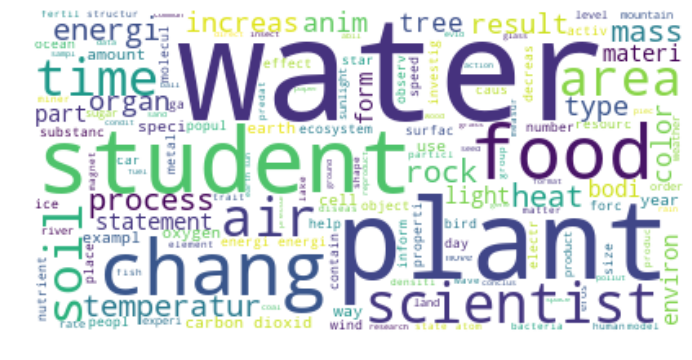

In [8]:
qtext = ''
for token in retokenized:
    qtext += token + ' '
wordcloud = WordCloud(background_color="white").generate(qtext)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

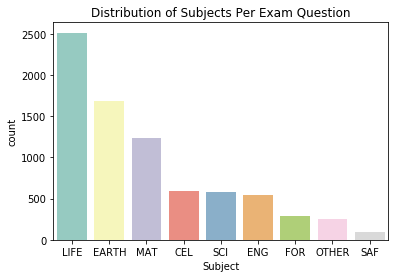

In [9]:
category = qc_questions['QCLabel'].apply(lambda x: x.split('_')[0]).apply(lambda x: 'LIFE' if x == 'OTHER, LIFE' else x)
qc_questions['Subject'] = category
plt.title('Distribution of Subjects Per Exam Question')
sns.countplot(x='Subject', data=qc_questions, palette="Set3", order = qc_questions['Subject'].value_counts().index);

Above is a visualization of the distribution of the primary subjects of each question pre-assigned by the ARC. As we can see, Life science, Earth Science, and Material Science (along with a focus on matters and measurements in physics) predominantly represent the majority of the question bank.

## TF-IDF Vectorization and MiniBatch K-Means

As an initial next step, to visualization how each exam question is phrased and the simillarity/difference among them across different subjects, we will compute the TF-IDF values as part of our feature extraction process and attempt to run an initial MiniBatch K-means clustering algorithm on the data.

As a first step, we will obtain the feature matrix on all the questions using the TfidfVectorizer.

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulshao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
qc_questions['Q_cleaned'] = qc_questions['Question'].apply(clean_text).str.replace('\d+', '')
vec = TfidfVectorizer(stop_words="english")
vec.fit(qc_questions['Q_cleaned'].values)
features = vec.transform(qc_questions['Q_cleaned'].values)

In order to determine how many clusters we would like our K-means algorithm to aim for, we can start with a random guess and gradually increase the number of clusters.

In [12]:
cls_s = []
for i in range(5, 15):
    cls = MiniBatchKMeans(n_clusters=i, random_state=0)
    cls.fit(features)
    cls_s.append(cls)

In [13]:
for cls in cls_s:
    cls.predict(features)

To visualize, we’ll plot the features in a 3D space. As we know the dimension of features that we obtained from TfIdfVectorizer could be quite large, we need to reduce the dimension before we can plot. For this, we’ll ues PCA to transform our high dimensional features into 3 dimensions.


**Note: As we hover over individual data points (exam questions) in the 3D scatterplot below, we can see the corresponding subject for the question.**

In [14]:
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(features.toarray())
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

#### 5 Clusters

In [15]:
import plotly.graph_objects as go
fig = go.Figure(data=[
                      go.Scatter3d(x=reduced_features[:,0], y=reduced_features[:,1], z=reduced_features[:,2],
                                   mode='markers',text=qc_questions['Subject'], marker=dict(size=4,color=cls_s[0].predict(features),                
                                  colorscale='Rainbow',opacity=0.6)),
                      go.Scatter3d(x=reduced_cluster_centers[:,0], y=reduced_cluster_centers[:,1], z=reduced_cluster_centers[:,2],
                                   mode='markers',marker=dict(size=6, symbol='x', color='rgb(0, 0, 0)'))
                      ]
                )
fig.update_layout( 
    scene = dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3'
    ),
    title='K-Means Clustering of Exam Questions (5 Clusters)'
)
fig.show()

#### 10 Clusters

In [16]:
fig = go.Figure(data=[
                      go.Scatter3d(x=reduced_features[:,0], y=reduced_features[:,1], z=reduced_features[:,2],
                                   mode='markers',text=qc_questions['Subject'], marker=dict(size=4,color=cls_s[5].predict(features),                
                                  colorscale='Rainbow',opacity=0.6)),
                      go.Scatter3d(x=reduced_cluster_centers[:,0], y=reduced_cluster_centers[:,1], z=reduced_cluster_centers[:,2],
                                   mode='markers',marker=dict(size=6, symbol='x', color='rgb(0, 0, 0)'))
                      ]
                )
fig.update_layout( 
    scene = dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3'
    ),
    title='K-Means Clustering of Exam Questions (10 Clusters)'
)
fig.show()

#### 15 clusters

In [17]:
fig = go.Figure(data=[
                      go.Scatter3d(x=reduced_features[:,0], y=reduced_features[:,1], z=reduced_features[:,2],
                                   mode='markers', text=qc_questions['Subject'], marker=dict(size=4,color=cls_s[-1].predict(features),                
                                  colorscale='Rainbow',opacity=0.6)),
                      go.Scatter3d(x=reduced_cluster_centers[:,0], y=reduced_cluster_centers[:,1], z=reduced_cluster_centers[:,2],
                                   mode='markers',marker=dict(size=6, symbol='x', color='rgb(0, 0, 0)'))
                      ]
                )

fig.update_layout( 
    scene = dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3'
    ),
    title='K-Means Clustering of Exam Questions (15 Clusters)'
)
fig.show()

As we can see above, with a pre-determined set of 15 clusters and a principle component analysis (PCA) in 3 dimensions, we can see that the topics are broken down along mainly 3 categories: Engineering, Cell Biology, and Earth/Material Science. Toward the center, the topics are concentrated on Forensics and Life Science.

### LDA (Latent Dirichlet Allocation)

LDA (Latent Dirichlet Allocation) is a generative statistical model that used unsupervised learning to group texts together by extracting the underlying topics and comparing their levels of similarity and marginal frequencies.
Here, when applying a pre- determined 20 topics, we can see that the topics are further divided into the following main subjects:

- Life Science (Organisms)
- Earth Science (Ecology)
- Measurement (Experiments)
- Biology (Cells and Chemistry)
- Earth Science (Geology)
- Physics (Energy and Matters)
- Miscellaneous (Students)

In [18]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(qc_questions['Question'])

def count_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 20
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

print("Topics found via LDA:")
count_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
carbon oxygen dioxide nitrogen water hydrogen photosynthesis atmosphere process trait

Topic #1:
stars star objects earth likely planets mineral universe solar planet

Topic #2:
energy plants plant water soil sunlight chemical heat food oil

Topic #3:
food number birds behavior eggs elements bird small chemical atomic

Topic #4:
water liquid temperature ice air solid gas change ocean heat

Topic #5:
organisms food best species fur bacteria disease animal animals helps

Topic #6:
weather hot data experiment dog investigation used heat time best

Topic #7:
rock rocks fossils formed erosion weathering electrical sedimentary likely form

Topic #8:
object core force box mass egg change mars speed mantle

Topic #9:
color stars winter best following summer relationship sky years animals

Topic #10:
earth sun moon gravity force axis day year distance surface

Topic #11:
light sound waves ball air heat atom wave electron energy

Topic #12:
mass measure used stud

#### Visualizing the LDA Topic Modeling Results

In [19]:
LDAvis_data_filepath = 'ldavis_prepared_'+str(number_topics)
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

In [20]:
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(number_topics) +'.html')

In [21]:
pyLDAvis.display(LDAvis_prepared)

The Intertopic Distance Map above represents the similarity between each topical cluster by computing the Jensen- Shannon divergence and applying PCA to project their distances onto a 2D plane for ease of visualization.

$\lambda$ here represents the relevance of a word. A term relevance is determined by their topic-specific probability: the marginal probability the specific term appears within the given topical cluster.

### LSTM-RNN Modeling

An LSTM-based RNN is a state-of-the-art (SOTA) deep learning architecture that performs well in predicting time-series data and working with sequence models.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" alt="LSTM-Chain" width="500"/>

Here, an LTSM-based RNN is trained on a TF- IDF vectorized matrix containing tokens of the ACR Exam questions to predict the underlying subject (one-hot encoded) of the question. Overall a total of 10 training epochs using the Adams optimizer, we can achieve ~76% test accuracy.

In [0]:
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [0]:
MAX_WORD_COUNT = 5000
MAX_SEQ_SIZE = 50
EMBEDDING_DIM = 50
EPOCHS = 10
BATCH_SIZE = 32

In [0]:
category = qc_questions['QCLabel'].apply(lambda x: x.split('_')[0]).apply(lambda x: 'LIFE' if x == 'OTHER, LIFE' else x)
qc_questions['Subject'] = category

In [0]:

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [0]:
qc_questions['Q_cleaned'] = qc_questions['Question'].apply(clean_text).str.replace('\d+', '')

In [0]:
tokenizer = Tokenizer(num_words=MAX_WORD_COUNT, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(qc_questions['Q_cleaned'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10719 unique tokens.


In [0]:
X = tokenizer.texts_to_sequences(qc_questions['Q_cleaned'].values)
X = pad_sequences(X, maxlen=MAX_SEQ_SIZE)
print('Shape of Design Matrix:', X.shape)

Shape of Design Matrix: (7787, 50)


In [0]:
y = pd.get_dummies(qc_questions['Subject']).values
print('Shape of Response Vector:', y.shape)

Shape of Response Vector: (7787, 9)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6618, 50) (6618, 9)
(1169, 50) (1169, 9)


In [0]:
model = Sequential()
model.add(Embedding(MAX_WORD_COUNT, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(50))
model.add(Dense(9, activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 50)            250000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 459       
Total params: 270,659
Trainable params: 270,659
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5956 samples, validate on 662 samples
Epoch 1/10
5956/5956 [==============================] - 26s 4ms/step - loss: 2.3624 - accuracy: 0.5831 - val_loss: 1.9518 - val_accuracy: 0.7523
Epoch 2/10
5956/5956 [==============================] - 25s 4ms/step - loss: 1.5921 - accuracy: 0.7456 - val_loss: 2.3677 - val_accuracy: 0.2900
Epoch 3/10
5956/5956 [==============================] - 25s 4ms/step - loss: 1.1511 - accuracy: 0.6187 - val_loss: 1.2828 - val_accuracy: 0.7447
Epoch 4/10
5956/5956 [==============================] - 25s 4ms/step - loss: 0.6156 - accuracy: 0.8716 - val_loss: 1.5353 - val_accuracy: 0.7795
Epoch 5/10
5956/5956 [==============================] - 25s 4ms/step - loss: 0.4157 - accuracy: 0.9256 - val_loss: 2.0267 - val_accuracy: 0.7855
Epoch 6/10
5956/5956 [==============================] - 25s 4ms/step - loss: 0.3279 - accuracy: 0.9466 - val_loss: 2.1312 - val_accuracy: 0.7779
Epoch 7/10
5956/5956 [==============================] - 25s 4ms/step - loss: 0.6632

In [0]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1169/1169 [==============================] - 0s 334us/step
Test set
  Loss: 2.287
  Accuracy: 0.759


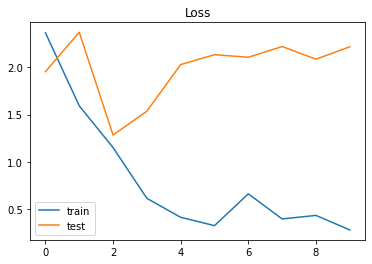

In [0]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

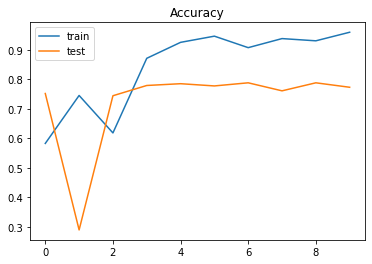

In [0]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();